In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import  minimize,NonlinearConstraint #optimization

### Fitting functions

This cell contains the fitting of the COP and the Heat data, which is later used in the simulation. Note that when the get-function of the COP is called, the COP_res is returned. The fit used, is a polynomial fit of third degree. 

In [3]:
from math import *
# Functions and Definitions for Data fitting
global COP_DATA     #define globally -> needs to be changed when iterating through the different configurations
global HEAT_DATA    #define globally -> needs to be changed when iterating through the different configurations
COP_DATA = []         
COP_POLY_COEFFS = np.array([])  
COP_POLY_DEGREE = 3   

HEAT_POLY_COEFFS = np.array([])  # will store polynomial coefficients
HEAT_POLY_DEGREE = 3             # adjust as needed


# generates the polynomial fit for the heat data, which can be called in every timestep in the simulation
def generate_heat_fit(heat_dict):
    global HEAT_POLY_COEFFS

    if not heat_dict:
        raise ValueError("No heat data to fit.")

    # Sort by temperature
    temps, heat_vals = zip(*sorted(heat_dict.items()))
    heat_vals = [i for i in heat_vals]
    # Fit polynomial
    HEAT_POLY_COEFFS = np.polyfit(temps, heat_vals, HEAT_POLY_DEGREE)


# returns the corresponding heat in respect to the passed-on temperature
def get_heat_from_fit(T):
    if HEAT_POLY_COEFFS is None or len(HEAT_POLY_COEFFS) == 0:
        raise RuntimeError("Heat polynomial fit has not been generated.")
    
    return float(np.polyval(HEAT_POLY_COEFFS, T))


# prints the equation of the fit
def print_heat_fit_equation():
    terms = [f"{coef:.6g} * T^{HEAT_POLY_DEGREE - i}" 
            for i, coef in enumerate(HEAT_POLY_COEFFS)]
    equation = " + ".join(terms)
    print("Heat(T) ≈", equation)


# stores the COP data 
def store_COP_data(param, T_si_in):
    cop_val = 1. / calc_COP(param)  # invert reciprocal COP
    COP_DATA.append((T_si_in, cop_val))
    return 1. / cop_val


# generates the COP fit  with a polynomial function of third degree
def generate_COP_fit():
    global COP_POLY_COEFFS
    if not COP_DATA:
        raise ValueError("No COP data to fit.")
    COP_DATA.sort(key=lambda x: x[0])
    T_vals, cop_vals = zip(*COP_DATA)
    COP_POLY_COEFFS = np.polyfit(T_vals, cop_vals, COP_POLY_DEGREE)


# returns the COP from the fitted function for every Temperature and Demand 
# note, the resulting COP is passed on
def get_COP_from_fit(T_si_in,Q_demand):#returns COP_res
    if COP_POLY_COEFFS is None or len(COP_POLY_COEFFS) == 0:
        raise RuntimeError("COP polynomial fit has not been generated.")
    Q_hp = get_heat_from_fit(T_si_in)
    factor = (Q_demand/Q_hp)/(0.9*Q_demand/Q_hp + 0.1)
    
    return float(np.polyval(COP_POLY_COEFFS, T_si_in)) * (factor)

# calculates the COP for the T_co and T_ev combination given
def calc_COP(param): 
    hp_vals = HP(param)

    state1 = hp_vals["state1"]

    state3= hp_vals["state3"]

    state2= hp_vals["state2"]

    #spec. heat released in the condenser
    q_high=state2["h"]-state3["h"] #kJ/kg
    #spec. compressor work
    w_comp=state2["h"]-state1["h"]  #kJ/kg
    #coefficient of performance 

    COP=q_high/w_comp
    #return reciprocal value of COP
    return 1./COP


# prints the fitted equation of the COP 
def print_COP_fit_equation():
    if len(COP_POLY_COEFFS) == 0:
        raise RuntimeError("Fit not generated yet.")

    terms = [f"{coef:.6g} * T^{COP_POLY_DEGREE - i}" 
        for i, coef in enumerate(COP_POLY_COEFFS)]
    equation = " + ".join(terms)
    print("COP(T_si_in) ≈", equation)


### Reading in file with Heat and COP data for fitting

In [4]:
# --- Read in textfile containing the results of the simulation ---
# contains COP and heat data for every configuration and different sink temperatures, to make the fit 
# alternative way, can be deleted. 

results = {}

with open("heat_pump_results.txt", "r") as file:
    lines = file.readlines()

i = 0
while i < len(lines):
    line = lines[i].strip()

    if line.startswith("DIA="):
        # --- Parse metadata ---
        meta = dict(item.split("=") for item in line.split(", "))
        dia = int(meta["DIA"])
        fluid = meta["FLUID"]

        # Prepare nested dictionary
        if dia not in results:
            results[dia] = {}
        results[dia][fluid] = {}

        # --- Parse COP_DATA ---
        i += 1  # move to next line (should be 'COP_DATA:')
        assert lines[i].strip() == "COP_DATA:"
        i += 1
        cop_data = []
        while i < len(lines) and "," in lines[i]:
            temp, val = map(float, lines[i].strip().split(","))
            cop_data.append((temp, val))
            i += 1
        results[dia][fluid]["COP_DATA"] = cop_data

        # --- Parse HEAT_DATA ---
        assert lines[i].strip() == "HEAT_DATA:"
        i += 1
        heat_data = []
        while i < len(lines) and "," in lines[i]:
            temp, val = map(float, lines[i].strip().split(","))
            heat_data.append((temp, val))
            i += 1
        results[dia][fluid]["HEAT_DATA"] = heat_data

        # --- Move past END_ENTRY ---
        while i < len(lines) and lines[i].strip() != "END_ENTRY":
            i += 1
        i += 1  # Skip 'END_ENTRY' line

    else:
        i += 1  # Skip irrelevant lines



## Control Strategy with heat-up included

### Defining variables

In [5]:
# --- Global control variables ---
HP = 1  # initial state of the heat pump: 1 = ON, 0 = OFF
time = 0  # timer to record operating time

# --- Constants and parameters ---
R_env = 30 / 1000    # K/W£
R_pasta = 15 / 1000  # K/W
c_l = 4.18 * 1000    # J/kg·K water
c_pasta = 3.5 * 1000 # J/kg·K pasta

T_env = 20      # °C
T_pasta_0 = 7        # °C
rho_water = 997.     # kg/m3

# --- Dimensions of the water tank ---
V_water = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1000# L
m_water = V_water / 1e3 * rho_water  # kg
m_pasta = 2 # kg


### Defining pasta cooking schedule 

In [6]:
# --- Pasta batch schedule (7 min cook, 5 min break) ---
# could also be adapted if a new schedule was needed

#returns a binary list that indicates if pasta is in the water or not 
def make_pasta_list(t):
    pasta_counter = 7 * 60
    break_counter = 5 * 60
    pasta_presence = np.zeros(len(t))
    pasta_taking_out_times = np.zeros(len(t))
    
    for i in range(len(t)):
        if pasta_counter == 0:
            pasta_taking_out_times[i] = 1
        if pasta_counter > 0:
            pasta_presence[i] = 1
            pasta_counter -= 1
        elif break_counter > 0:
            pasta_presence[i] = 0
            break_counter -= 1
        else:
            pasta_counter = 7 * 60 - 1
            break_counter = 5 * 60
            pasta_presence[i] = 1
    return pasta_presence


#returns a binary list that indicates the time at which the pasta is taken out 
#needed for the controlling -> if pasta reaches 85°C
def make_pasta_starting_list(t):
    pasta_counter = 7 * 60
    break_counter = 5 * 60
    pasta_presence = np.zeros(len(t))
    pasta_taking_out_times = np.zeros(len(t))
    
    for i in range(len(t)):
        if pasta_counter == 1:
            pasta_taking_out_times[i] = 1
        if pasta_counter > 0:
            pasta_presence[i] = 1
            pasta_counter -= 1
        elif break_counter > 0:
            pasta_presence[i] = 0
            break_counter -= 1
        else:
            pasta_counter = 7 * 60 - 1
            break_counter = 5 * 60
            pasta_presence[i] = 1
    return pasta_taking_out_times

### Define heat pump control logic

In [7]:
# --- Heat pump control logic ---
# works with the global variable "HP" and calls the get-heat-function to return the amount of heat input into the system

def calc_HP(T, T_on, T_off, op_times):
    global HP, time
    # time counts how long the heat pump operates for one operation
    # HP signals if the heatpump is on or off

    # If Temperature falls below minimal threshold value --> turn heat pump on
    if T <= T_on: # Temperature is below T
        if HP == 0:
            time = 0
        HP = 1

    # If Temperature is above maximum threshold --> turn heat pump off
    elif T >= T_off:
        if HP == 1:
            op_times.append(time)
        HP = 0

    # If the Heatpump is on, increase operation time and calculate heat output for the respective sink temperature with the fit
    # Else output of the heatpump is zero at this timestel
    if HP == 1:
        time += 1
        return get_heat_from_fit(T) * 1000
    else:
        return 0

### Define Temperature ODE's for system

In [8]:
# --- ODE for water only ---

# accounts for the cooling phase in which there is no pasta in the water, so the 5min in between 
def temp_store_only_water(T_water, t, Q_WP, m_water, c_water):
    dT_waterdt = (Q_WP - (T_water - T_env) / R_env) / (m_water * c_water)
    return dT_waterdt

# --- ODE for water + pasta ---

# accounts for the cooking phase, when pasta is in the water 
def temp_store_with_pasta(T, t, Q_WP, m_water, m_pasta, c_water, c_pasta):
    T_water, T_pasta = T
    dT_waterdt = (Q_WP - (T_water - T_env) / R_env - (T_water - T_pasta) / R_pasta) / (m_water * c_water)
    dT_pastadt = ((T_water - T_pasta) / R_pasta) / (m_pasta * c_pasta)
    return [dT_waterdt, dT_pastadt]

### Define the main simulation

In [9]:
# --- Main simulation ---

# simulation over the entire time without heating-up phase 
def T_water_and_pasta(T_WP_on, T_WP_off, duration_s,op_times, V_store):
    t = np.linspace(0, duration_s, duration_s)
    T_water = np.zeros(duration_s)
    T_pasta = np.full(duration_s, T_pasta_0, dtype=float)
    Q_WPs = np.zeros(duration_s)
    Q_demand = np.zeros(duration_s)

    T0_water = T_WP_on
    T0_pasta = T_pasta_0
    T_water[0] = T0_water
    T_pasta[0] = T0_pasta

    m_store = V_store / 1e3 * rho_water # kg
    m_pasta = 2  # kg

    binary_pasta = make_pasta_list(t)

    global WP, time
    WP = 1
    time = 0

    for i in range(1, duration_s):
        if binary_pasta[i] == 0:
            tspan = [t[i - 1], t[i]]
            z = odeint(temp_store_only_water, T0_water, tspan, args=(Q_WPs[i - 1], m_store, c_l))
            T0_water = z[1][0]
            T0_pasta = T_pasta_0
            Q_demand[i] = m_store * c_l * (T0_water - T_water[i - 1])
        else:
            tspan = np.linspace(t[i - 1], t[i], 10)
            T_function = [T0_water, T0_pasta]
            sol = odeint(temp_store_with_pasta, T_function, tspan, args=(Q_WPs[i - 1], m_store, m_pasta, c_l, c_pasta))
            T0_water = sol[-1, 0]
            T0_pasta = sol[-1, 1]
            Q_demand[i] = (
                m_store * c_l * (T0_water - T_water[i - 1]) +
                m_pasta * c_pasta * (T0_pasta - T_pasta[i - 1])
                )

        Q_WPs[i] = calc_HP(T0_water, T_WP_on, T_WP_off, op_times)
        T_water[i] = T0_water
        T_pasta[i] = T0_pasta

    return t, Q_WPs, T_water, T_pasta, Q_demand


# --- Main simulation with morning heat-up ---

# simulation over the entire operation with heating-up phase 
def T_water_and_pasta_with_heatup(T_WP_on, T_WP_off, duration_s, op_times, m_water, m_pasta):
    t = np.linspace(0, duration_s, duration_s)
    T_water = np.zeros(duration_s)
    T_pasta = np.full(duration_s, T_pasta_0, dtype=float)
    Q_WPs = np.zeros(duration_s)

    T0_water = T_env  # Start at room temp
    T0_pasta = T_pasta_0
    T_water[0] = T0_water
    T_pasta[0] = T0_pasta

    binary_pasta = np.zeros(duration_s)
    
    pasta_schedule_started = False
    pasta_schedule_start_index = None

    for i in range(1, duration_s):
        if not pasta_schedule_started and T0_water >= T_WP_off:
            pasta_schedule_start_index = i
            binary_pasta[i:] = make_pasta_list(np.arange(duration_s - i))
            pasta_schedule_started = True

        if binary_pasta[i] == 0:
            tspan = [t[i - 1], t[i]]
            z = odeint(temp_store_only_water, T0_water, tspan, args=(Q_WPs[i - 1], m_water, c_l))
            T0_water = z[1][0]
            T0_pasta = T_pasta_0

        else:
            tspan = np.linspace(t[i - 1], t[i], 10)
            T_function = [T0_water, T0_pasta]
            sol = odeint(temp_store_with_pasta, T_function, tspan, args=(Q_WPs[i - 1], m_water, m_pasta, c_l, c_pasta))
            T0_water = sol[-1, 0]
            T0_pasta = sol[-1, 1]

        Q_WPs[i] = calc_HP(T0_water, T_WP_on, T_WP_off, op_times)
        T_water[i] = T0_water
        T_pasta[i] = T0_pasta

    return t, Q_WPs, T_water, T_pasta, pasta_schedule_start_index


### Running the simulation

#### Iteration through all configurations and find solution via grid search 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Parameters
list_with_best_results = []
diameters = [35, 40, 45, 50]
fluids = ['Isobutene', 'Isobutane', 'Butane', 'DimethylEther']
T_on_range = np.arange(85, 89.01, 0.2)
T_off_range = np.arange(87, 93.01, 0.2)  
duration_seconds = 12 * 60 * 60
cycles = 60

# Output file
with open("grid_search_log.txt", "w") as f:
    f.write("Dia,Fluid,T_on,T_off,Valid,Power_kWh,Min_T,Max_T,Pasta_Ts\n")

# Loop over all combinations
for dia, fluid in itertools.product(diameters, fluids):
    if dia not in results or fluid not in results[dia]:
        print(f"⚠️ Skipping missing combo DIA={dia}, FLUID={fluid}")
        continue

    try:
        print(f"\n🚀 Starting search for DIA={dia}, FLUID={fluid}")

        # Reset global data stores
        COP_DATA.clear()
        HEAT_POLY_COEFFS = []
        COP_POLY_COEFFS = []

        # --- 1. Get Data ---
        data = results[dia][fluid]
        COP_DATA.extend(data["COP_DATA"])
        heat_dict = dict(data["HEAT_DATA"])

        # --- 2. Fit and Plot ---
        generate_COP_fit()
        generate_heat_fit(heat_dict)

        #fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        #x_cop = np.linspace(min(dict(COP_DATA).keys()), max(dict(COP_DATA).keys()), 100)
        #x_heat = np.linspace(min(heat_dict.keys()), max(heat_dict.keys()), 100)

        #ax[0].plot(x_cop, [np.polyval(COP_POLY_COEFFS, x) for x in x_cop], '-', label="Fit")
        #ax[0].plot(*zip(*COP_DATA), 'o', label="COP Data")
        #ax[0].set_title(f"COP Fit - {fluid}, DIA={dia}")
        #ax[0].legend()
        
        #ax[1].plot(*zip(*heat_dict.items()), 'o', label="HEAT Data")
        #ax[1].plot(x_heat, [np.polyval(HEAT_POLY_COEFFS, x) for x in x_heat], '-', label="Fit")
        #ax[1].set_title(f"HEAT Fit - {fluid}, DIA={dia}")
        #ax[1].legend()

        #plt.tight_layout()
        #plt.savefig(f"fit_DIA{dia}_{fluid}.png", dpi=200)
        #plt.close()

        # --- 3. Optimization Loop ---
        best_result = None
        best_power = np.inf
        valid_found = False
        skip_due_to_pasta_temp = False

        binary_pasta = make_pasta_list(np.linspace(0, duration_seconds, duration_seconds))
        binary_taking_out_pasta = make_pasta_starting_list(np.linspace(0, duration_seconds, duration_seconds))

        for T_on, T_off in itertools.product(T_on_range, T_off_range):
            if T_on >= T_off:
                continue

            try:
                t, Q_WP, T_water, T_pasta, Q_demand = T_water_and_pasta(T_on, T_off, duration_seconds, [], dia)
                end_pasta_Ts = T_pasta[np.where(binary_taking_out_pasta == 1)]

                #if len(end_pasta_Ts) > 0 and end_pasta_Ts[cycles-1] > 86:
                    #print(f"⛔ Skipping entire {fluid}-{dia} early due to first pasta temp = {end_pasta_Ts[0]:.2f}°C > 86°C")
                    #skip_due_to_pasta_temp = True
                    #break

                min_T = np.min(T_water)
                max_T = np.max(T_water)
                valid = (
                    85 <= min_T <= 93 and
                    85 <= max_T <= 93 and
                    np.all((85 <= end_pasta_Ts) & (end_pasta_Ts <= 86))
                )

                if not valid:
                    with open("grid_search_log.txt", "a") as f:
                        f.write(f"{dia},{fluid},{T_on:.2f},{T_off:.2f},False,NA,{min_T:.2f},{max_T:.2f},{end_pasta_Ts.tolist()}\n")
                    continue

                valid_found = True

                # Compute power
                power = 0
                for i in range(len(Q_WP)):
                    if Q_WP[i] > 0:
                        cop = max(get_COP_from_fit(T_water[i], Q_demand[i]), 0.01)
                        power += Q_WP[i] / (cop * 1000)

                if power < best_power:
                    best_power = power
                    best_result = (T_on, T_off)

                with open("grid_search_log.txt", "a") as f:
                    f.write(f"{dia},{fluid},{T_on:.2f},{T_off:.2f},True,{power:.2f},{min_T:.2f},{max_T:.2f},{end_pasta_Ts.tolist()}\n")

                print(f"✅ {fluid}-{dia}: T_on={T_on:.2f}, T_off={T_off:.2f} → Power={power:.2f} kWh")
                list_with_best_results.append({
                    "diameter": dia,
                    "fluid": fluid,
                    "T_on": T_on,
                    "T_off": T_off,
                    "power": power,
                })
                #print(list_with_best_results)

            except Exception as e:
                print(f"⚠️ Error for {fluid}-{dia} (T_on={T_on:.2f}, T_off={T_off:.2f}): {e}")
                with open("grid_search_log.txt", "a") as f:
                    f.write(f"{dia},{fluid},{T_on:.2f},{T_off:.2f},Error,NA,NA,NA,NA\n")

        # Store result
        #if skip_due_to_pasta_temp:
            #print(f"❌ Skipped entire combo {fluid}-{dia} due to high initial pasta temp.")
            #with open("grid_search_log.txt", "a") as f:
                #f.write(f"{dia},{fluid},NA,NA,SkippedDueToPastaTemp,NA,NA,NA,NA\n")

        if best_result is not None:
            print(f"🎯 Best for {fluid}-{dia}: T_on = {best_result[0]:.2f}, T_off = {best_result[1]:.2f}, Power = {best_power:.2f} kWh")

    except Exception as e:
        print(f"❌ Global failure for {fluid}-{dia}: {e}")



⚠️ Skipping missing combo DIA=35, FLUID=Isobutene

🚀 Starting search for DIA=35, FLUID=Isobutane


✅ Isobutane-35: T_on=86.80, T_off=87.00 → Power=55794.29 kWh
✅ Isobutane-35: T_on=86.80, T_off=87.20 → Power=55970.26 kWh
✅ Isobutane-35: T_on=86.80, T_off=87.40 → Power=56048.91 kWh
✅ Isobutane-35: T_on=86.80, T_off=87.60 → Power=56156.41 kWh
✅ Isobutane-35: T_on=86.80, T_off=87.80 → Power=56640.01 kWh
✅ Isobutane-35: T_on=86.80, T_off=88.00 → Power=56305.68 kWh
✅ Isobutane-35: T_on=86.80, T_off=88.80 → Power=56871.98 kWh
✅ Isobutane-35: T_on=86.80, T_off=89.00 → Power=56494.63 kWh
✅ Isobutane-35: T_on=86.80, T_off=89.20 → Power=56803.70 kWh
✅ Isobutane-35: T_on=86.80, T_off=89.40 → Power=57111.50 kWh
✅ Isobutane-35: T_on=86.80, T_off=89.60 → Power=57420.07 kWh
✅ Isobutane-35: T_on=87.00, T_off=87.20 → Power=55989.53 kWh
✅ Isobutane-35: T_on=87.00, T_off=87.40 → Power=56316.02 kWh
✅ Isobutane-35: T_on=87.00, T_off=87.60 → Power=56395.75 kWh
✅ Isobutane-35: T_on=87.00, T_off=87.80 → Power=56495.52 kWh
✅ Isobutane-35: T_on=87.00, T_off=88.00 → Power=56755.29 kWh
✅ Isobutane-35: T_on=87.

### Extract best result

In [10]:
import json

print(list_with_best_results)
# Filter valid entries (power is not NaN)
valid_results = [r for r in list_with_best_results if not np.isnan(r['power'])]



with open("valid_results.txt", "w") as f:
    json.dump(valid_results, f, indent=4)



NameError: name 'list_with_best_results' is not defined

In [12]:
import json

with open("valid_results.txt", "r") as f:
    valid_results = json.load(f)
    
# Find the best one (lowest power)
best_config = min(valid_results, key=lambda x: x['power']) if valid_results else None

# Extract values
if best_config:
    best_fluid = best_config['fluid']
    best_dia = best_config['diameter']
    best_T_on = best_config['T_on']
    best_T_off = best_config['T_off']
    best_power = best_config['power']

    print("✅ Best config found:")
    print(f"  Fluid:     {best_fluid}")
    print(f"  Diameter:  {best_dia}")
    print(f"  T_on:      {best_T_on}")
    print(f"  T_off:     {best_T_off}")
    print(f"  Power:     {best_power:.2f} kWh")
else:
    print("❌ No valid configuration found with non-NaN power.")

✅ Best config found:
  Fluid:     Butane
  Diameter:  40
  T_on:      86.80000000000003
  T_off:     87.0
  Power:     53315.50 kWh


### Create Fit

In [13]:

COP_DATA.clear()
HEAT_POLY_COEFFS = []
COP_POLY_COEFFS = []
print(results)

# --- 1. Get Data ---
data = results[best_dia][best_fluid]
COP_DATA.extend(data["COP_DATA"])
heat_dict = dict(data["HEAT_DATA"])

# --- 2. Fit and Plot ---
generate_COP_fit()
generate_heat_fit(heat_dict)

{35: {'Isobutane': {'COP_DATA': [(20.0, 5.9819), (25.21, 5.3715), (30.43, 4.8586), (35.64, 4.4211), (40.86, 4.0431), (46.07, 3.7128), (51.29, 3.4212), (56.5, 3.1613), (61.71, 2.9276), (66.93, 2.7156), (72.14, 2.522), (77.36, 2.3438), (82.57, 2.1788), (87.79, 2.0249), (93.0, 1.8806)], 'HEAT_DATA': [(20.0, 6.76), (25.21, 6.54), (30.43, 6.31), (35.64, 6.08), (40.86, 5.84), (46.07, 5.61), (51.29, 5.37), (56.5, 5.12), (61.71, 4.88), (66.93, 4.63), (72.14, 4.38), (77.36, 4.13), (82.57, 3.88), (87.79, 3.63), (93.0, 3.38)]}, 'DimethylEther': {'COP_DATA': [(20.0, 3.3753), (25.21, 3.1626), (30.43, 2.9722), (35.64, 2.8002), (40.86, 2.6438), (46.07, 2.5007), (51.29, 2.3688), (56.5, 2.2466), (61.71, 2.1328), (66.93, 2.0264), (72.14, 1.9264), (77.36, 1.8377), (82.57, 1.7502), (87.79, 1.6675), (93.0, 1.5895)], 'HEAT_DATA': [(20.0, 6.42), (25.21, 6.26), (30.43, 6.09), (35.64, 5.93), (40.86, 5.75), (46.07, 5.58), (51.29, 5.41), (56.5, 5.24), (61.71, 5.07), (66.93, 4.89), (72.14, 4.72), (77.36, 4.13), (

### Same grid search but without constraining upper temperature for pasta

### Controlling Plot

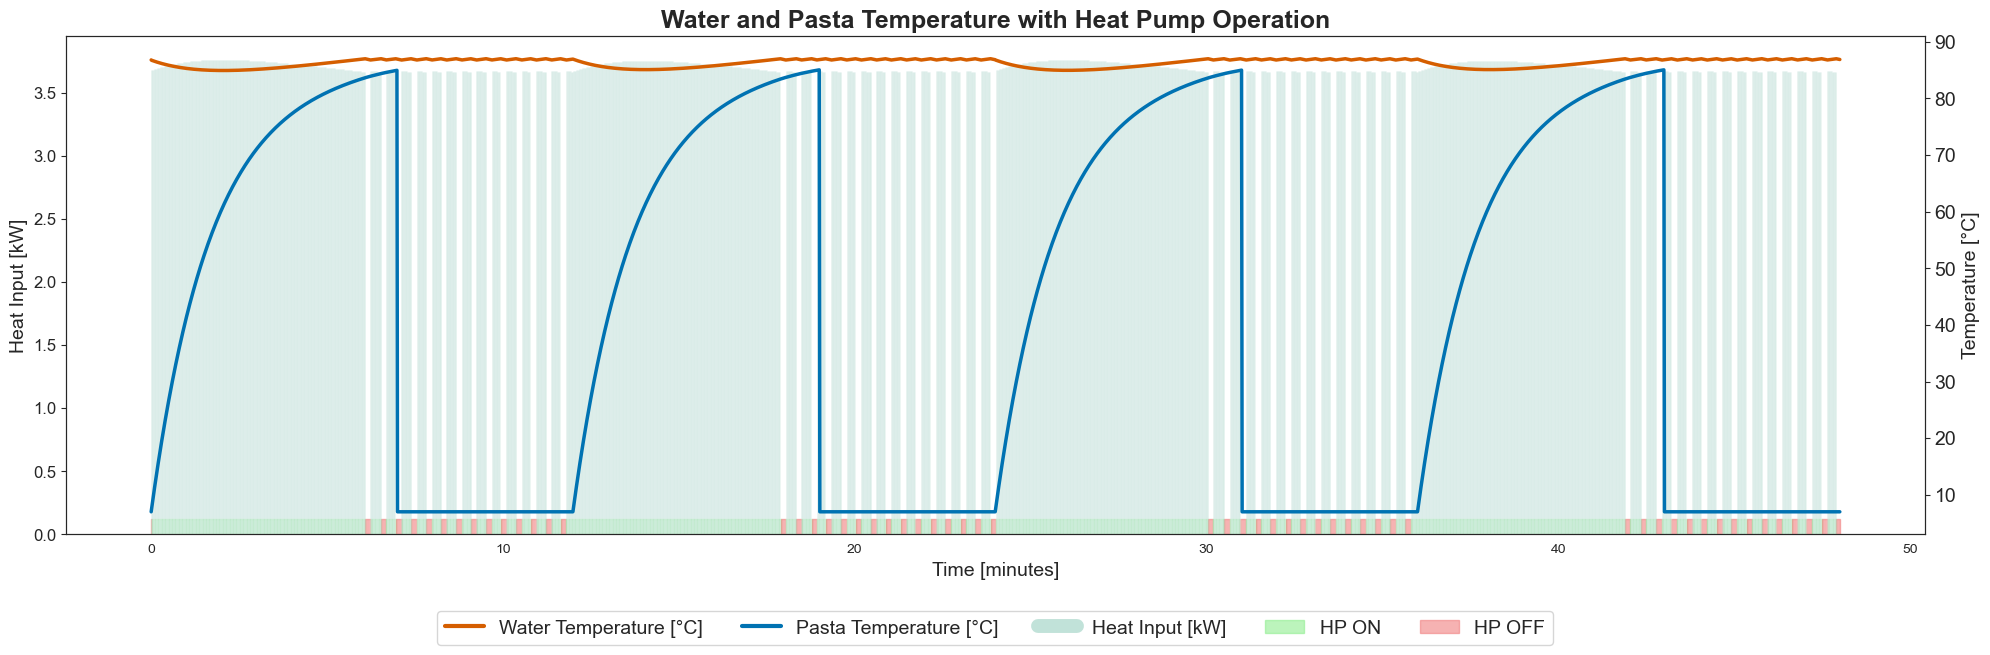

In [15]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import groupby
from matplotlib.lines import Line2D
import matplotlib.patches as patches

# --- Simulation (replace with your actual function call) ---
op_times = []
duration_seconds = 12 * 60 * 4
start_index = 0




t, Q_WPs, T_water, T_pasta, _ = T_water_and_pasta(
    best_T_on, best_T_off, duration_seconds, op_times, V_water
)

# --- Prepare DataFrame ---
time_min = t / 60
hp_binary = (np.array(Q_WPs) > 0).astype(int)
Q_kW = np.array(Q_WPs) / 1000

df = pd.DataFrame({
    "Time [min]": time_min,
    "T_water": T_water,
    "T_pasta": T_pasta,
    "Q_WP": Q_kW,
    "ON": hp_binary
})

# --- Style & Palette ---
sns.set_style("white")
palette = {
    "water": "#D55E00",
    "pasta": "#0072B2",
    "qwp": "#0A8E68",
    "on": "lightgreen",
    "off": "lightcoral"
}

# --- Create figure & axes ---
fig, ax_qwp = plt.subplots(figsize=(20, 6))     # Main plot: Q_WP (now background)
ax_temp = ax_qwp.twinx()                        # Secondary y-axis: temperature

# --- Heat Input bars on primary axis (background) ---
ax_qwp.bar(df["Time [min]"], df["Q_WP"],
           width=1/60, color=palette["qwp"], alpha=0.25, label="Heat Input [kW]")
ax_qwp.set_ylabel("Heat Input [kW]", fontsize=14)
ax_qwp.tick_params(axis='y', labelsize=12)

# --- Temperature lines on secondary axis (foreground) ---
ax_temp.plot(df["Time [min]"], df["T_water"],
             color=palette["water"], linewidth=2.5, label="Water Temp [°C]")
ax_temp.plot(df["Time [min]"], df["T_pasta"],
             color=palette["pasta"], linewidth=2.5, label="Pasta Temp [°C]")
ax_temp.set_ylabel("Temperature [°C]", fontsize=14)
ax_temp.tick_params(axis='y', labelsize=14)

# --- ON/OFF bars at bottom (on Q axis) ---
indices = np.arange(len(df))
blocks = []
for state, group in groupby(zip(indices, hp_binary), key=lambda x: x[1]):
    idxs = [i for i, _ in group]
    blocks.append((state, idxs[0], idxs[-1]))

ymin, ymax = ax_qwp.get_ylim()
band = (ymax - ymin) * 0.03
for state, start_i, end_i in blocks:
    t0 = time_min[start_i]
    t1 = time_min[end_i] + 1/60
    color = palette["on"] if state == 1 else palette["off"]
    ax_qwp.axvspan(t0, t1,
                   ymin=0.00, ymax=0.00 + 0.03,
                   color=color, alpha=0.6, zorder=0)

# --- Axis labels & title ---
ax_qwp.set_xlabel("Time [minutes]", fontsize=14)
ax_qwp.set_title("Water and Pasta Temperature with Heat Pump Operation", fontsize=18, weight='bold')

# --- Custom Legend (merged across axes) ---
legend_elements = [
    Line2D([0], [0], color=palette["water"], lw=3, label="Water Temperature [°C]"),
    Line2D([0], [0], color=palette["pasta"], lw=3, label="Pasta Temperature [°C]"),
    Line2D([0], [0], color=palette["qwp"], lw=10, alpha=0.25, label="Heat Input [kW]"),
    patches.Rectangle((0, 0), 1, 1, color=palette["on"], alpha=0.6, label="HP ON"),
    patches.Rectangle((0, 0), 1, 1, color=palette["off"], alpha=0.6, label="HP OFF")
]

fig.legend(handles=legend_elements, loc='lower center',
           ncol=5, bbox_to_anchor=(0.5, -0.1), fontsize=14)

plt.tight_layout()
plt.savefig("control_strategy.png", dpi=600)
plt.show()


### Best Case 

{35: {'Isobutane': {'COP_DATA': [(20.0, 5.9819), (25.21, 5.3715), (30.43, 4.8586), (35.64, 4.4211), (40.86, 4.0431), (46.07, 3.7128), (51.29, 3.4212), (56.5, 3.1613), (61.71, 2.9276), (66.93, 2.7156), (72.14, 2.522), (77.36, 2.3438), (82.57, 2.1788), (87.79, 2.0249), (93.0, 1.8806)], 'HEAT_DATA': [(20.0, 6.76), (25.21, 6.54), (30.43, 6.31), (35.64, 6.08), (40.86, 5.84), (46.07, 5.61), (51.29, 5.37), (56.5, 5.12), (61.71, 4.88), (66.93, 4.63), (72.14, 4.38), (77.36, 4.13), (82.57, 3.88), (87.79, 3.63), (93.0, 3.38)]}, 'DimethylEther': {'COP_DATA': [(20.0, 3.3753), (25.21, 3.1626), (30.43, 2.9722), (35.64, 2.8002), (40.86, 2.6438), (46.07, 2.5007), (51.29, 2.3688), (56.5, 2.2466), (61.71, 2.1328), (66.93, 2.0264), (72.14, 1.9264), (77.36, 1.8377), (82.57, 1.7502), (87.79, 1.6675), (93.0, 1.5895)], 'HEAT_DATA': [(20.0, 6.42), (25.21, 6.26), (30.43, 6.09), (35.64, 5.93), (40.86, 5.75), (46.07, 5.58), (51.29, 5.41), (56.5, 5.24), (61.71, 5.07), (66.93, 4.89), (72.14, 4.72), (77.36, 4.13), (

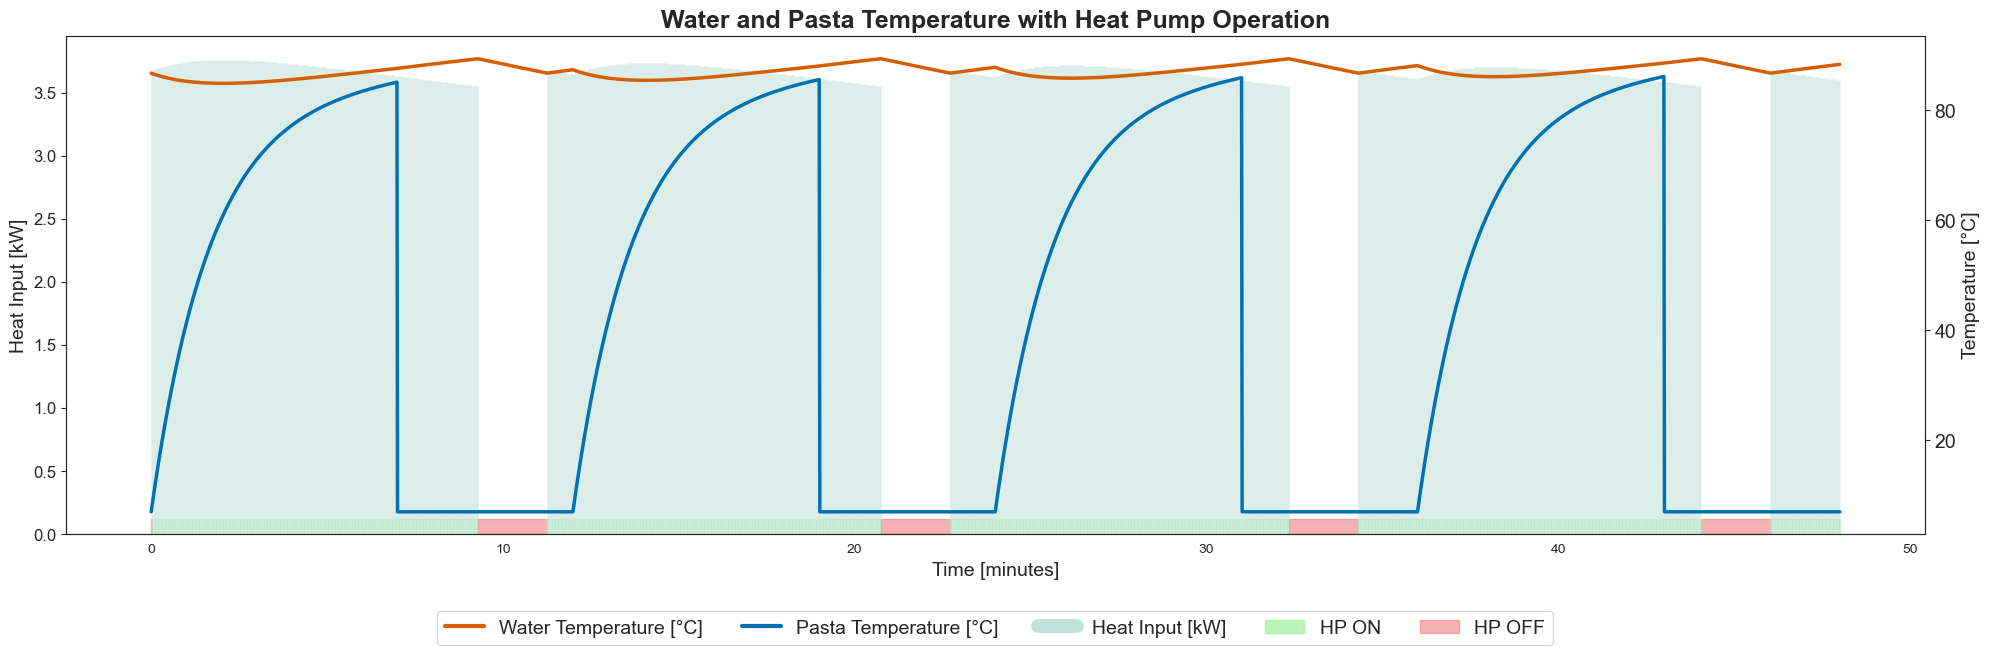

In [17]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import groupby
from matplotlib.lines import Line2D
import matplotlib.patches as patches


COP_DATA.clear()
HEAT_POLY_COEFFS = []
COP_POLY_COEFFS = []
print(results)

# --- 1. Get Data ---
data = results[40]['Butane']
COP_DATA.extend(data["COP_DATA"])
heat_dict = dict(data["HEAT_DATA"])

# --- 2. Fit and Plot ---
generate_COP_fit()
generate_heat_fit(heat_dict)


# --- Simulation (replace with your actual function call) ---
op_times = []
duration_seconds = 12 * 60 * 4
start_index = 0

best_T_on = 86.8
best_T_off = 89.4


t, Q_WPs, T_water, T_pasta, _ = T_water_and_pasta(
    best_T_on, best_T_off, duration_seconds, op_times, V_water
)

# --- Prepare DataFrame ---
time_min = t / 60
hp_binary = (np.array(Q_WPs) > 0).astype(int)
Q_kW = np.array(Q_WPs) / 1000

df = pd.DataFrame({
    "Time [min]": time_min,
    "T_water": T_water,
    "T_pasta": T_pasta,
    "Q_WP": Q_kW,
    "ON": hp_binary
})

# --- Style & Palette ---
sns.set_style("white")
palette = {
    "water": "#D55E00",
    "pasta": "#0072B2",
    "qwp": "#0A8E68",
    "on": "lightgreen",
    "off": "lightcoral"
}

# --- Create figure & axes ---
fig, ax_qwp = plt.subplots(figsize=(20, 6))     # Main plot: Q_WP (now background)
ax_temp = ax_qwp.twinx()                        # Secondary y-axis: temperature

# --- Heat Input bars on primary axis (background) ---
ax_qwp.bar(df["Time [min]"], df["Q_WP"],
           width=1/60, color=palette["qwp"], alpha=0.25, label="Heat Input [kW]")
ax_qwp.set_ylabel("Heat Input [kW]", fontsize=14)
ax_qwp.tick_params(axis='y', labelsize=12)

# --- Temperature lines on secondary axis (foreground) ---
ax_temp.plot(df["Time [min]"], df["T_water"],
             color=palette["water"], linewidth=2.5, label="Water Temp [°C]")
ax_temp.plot(df["Time [min]"], df["T_pasta"],
             color=palette["pasta"], linewidth=2.5, label="Pasta Temp [°C]")
ax_temp.set_ylabel("Temperature [°C]", fontsize=14)
ax_temp.tick_params(axis='y', labelsize=14)

# --- ON/OFF bars at bottom (on Q axis) ---
indices = np.arange(len(df))
blocks = []
for state, group in groupby(zip(indices, hp_binary), key=lambda x: x[1]):
    idxs = [i for i, _ in group]
    blocks.append((state, idxs[0], idxs[-1]))

ymin, ymax = ax_qwp.get_ylim()
band = (ymax - ymin) * 0.03
for state, start_i, end_i in blocks:
    t0 = time_min[start_i]
    t1 = time_min[end_i] + 1/60
    color = palette["on"] if state == 1 else palette["off"]
    ax_qwp.axvspan(t0, t1,
                   ymin=0.00, ymax=0.00 + 0.03,
                   color=color, alpha=0.6, zorder=0)

# --- Axis labels & title ---
ax_qwp.set_xlabel("Time [minutes]", fontsize=14)
ax_qwp.set_title("Water and Pasta Temperature with Heat Pump Operation", fontsize=18, weight='bold')

# --- Custom Legend (merged across axes) ---
legend_elements = [
    Line2D([0], [0], color=palette["water"], lw=3, label="Water Temperature [°C]"),
    Line2D([0], [0], color=palette["pasta"], lw=3, label="Pasta Temperature [°C]"),
    Line2D([0], [0], color=palette["qwp"], lw=10, alpha=0.25, label="Heat Input [kW]"),
    patches.Rectangle((0, 0), 1, 1, color=palette["on"], alpha=0.6, label="HP ON"),
    patches.Rectangle((0, 0), 1, 1, color=palette["off"], alpha=0.6, label="HP OFF")
]

fig.legend(handles=legend_elements, loc='lower center',
           ncol=5, bbox_to_anchor=(0.5, -0.1), fontsize=14)

plt.tight_layout()
plt.savefig("control_strategy.png", dpi=600)
plt.show()


### with heatup 

Calculated heating-up time = 36.4 minutes


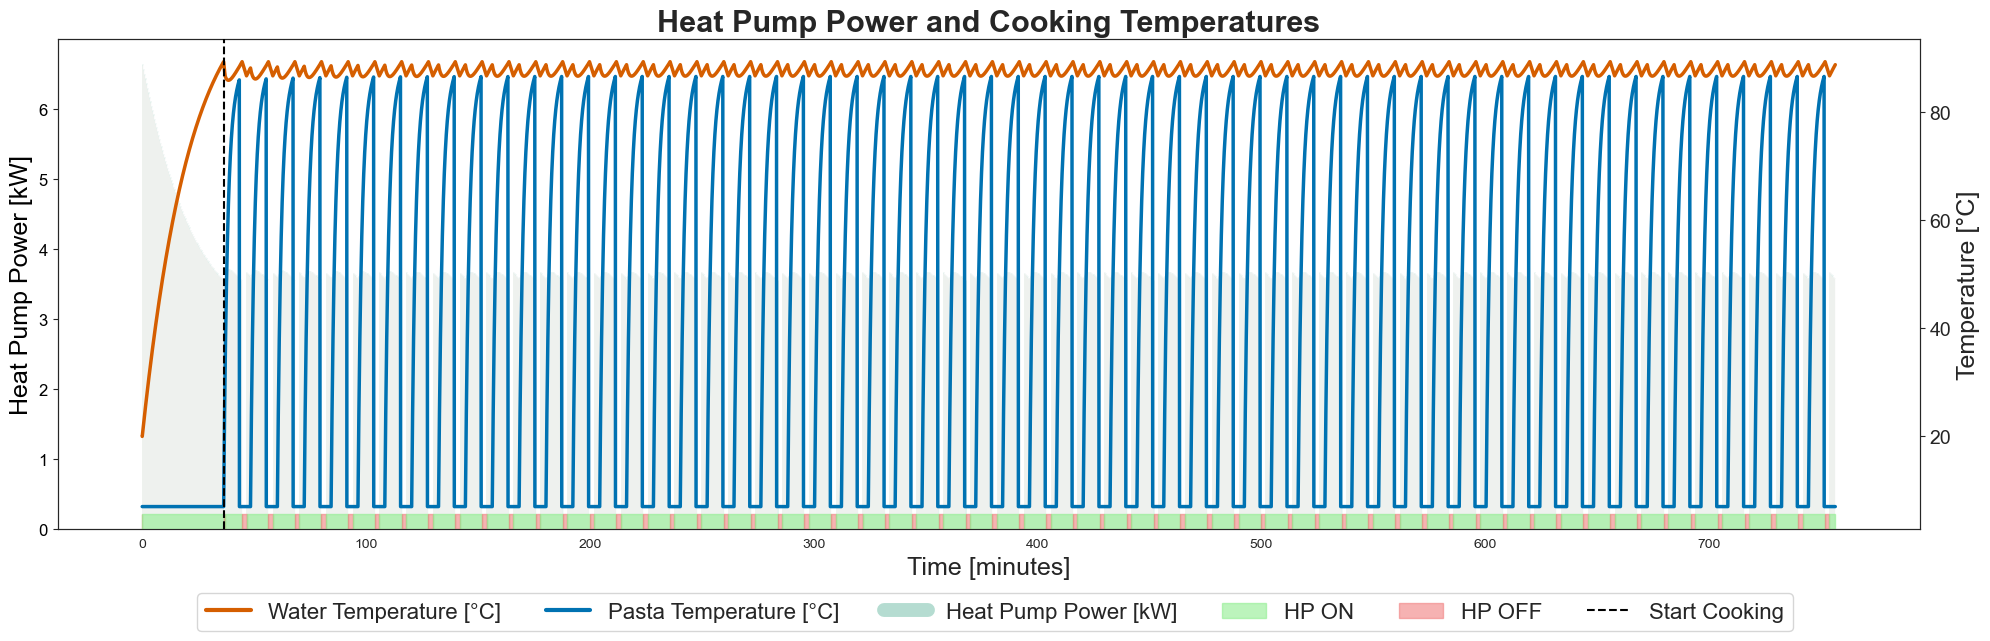

Time until cooking starts (heat-up) = 36.4 minutes
Min operating time = 7.58 minutes
Max operating time = 38.57 minutes
Number of heat pump on-cycles = 61
Total duration = 12.606666666666666 hours
Max T_water after heatup: 89.41107671935845
Min T_water after heatup: 85.96896334251534


In [34]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import groupby
from matplotlib.lines import Line2D
import matplotlib.patches as patches

# --- Step 1: Preliminary simulation to find heating-up time only ---
prelim_duration = 3 * 60 * 60  # simulate up to 3 hours for safety
op_times_prelim = []


# Run preliminary sim just to get heat-up time
_, _, T_water_prelim, _, prelim_start_index  = T_water_and_pasta_with_heatup(
    best_T_on, best_T_off, prelim_duration, op_times_prelim, m_water, m_pasta)

if prelim_start_index is None:
    raise RuntimeError("Cooking schedule never started. Increase preliminary duration or check parameters.")

heating_up_time = prelim_start_index  # in seconds
print("Calculated heating-up time =", heating_up_time / 60, "minutes")

# --- Simulation Data ---
duration_seconds = heating_up_time + 12 * 60 * 60
op_times = []
t, Q_WPs, T_water, T_pasta, start_index = T_water_and_pasta_with_heatup(
    best_T_on, best_T_off, duration_seconds, op_times, m_water, m_pasta
)

# --- Prepare DataFrame ---
time_min = t / 60
Q_kW = np.array(Q_WPs) / 1000
hp_binary = (np.array(Q_WPs) > 0).astype(int)

df = pd.DataFrame({
    "Time [min]": time_min,
    "T_water": T_water,
    "T_pasta": T_pasta,
    "Q_WP": Q_kW,
    "ON": hp_binary
})

# --- Style & Palette ---
sns.set_style("white")
palette = {
    "water": "#D55E00",
    "pasta": "#0072B2",
    "qwp": "#0A8E68",
    "on": "lightgreen",
    "off": "lightcoral"
}

# --- Create figure & axes ---
fig, ax = plt.subplots(figsize=(20, 6))  # ax = main = heat
ax2 = ax.twinx()                         # ax2 = twin = temperature

# --- Q_WP bars on main axis (background) ---
bar_width = time_min[1] - time_min[0]
ax.bar(df["Time [min]"], df["Q_WP"],
       width=bar_width, color=palette["qwp"], alpha=0.3, zorder=0)
ax.set_ylabel("Heat Pump Power [kW]", color='black', fontsize=18)
ax.tick_params(axis='y', labelsize=12, labelcolor='black')

# --- Temperature lines on foreground twin axis ---
ax2.plot(df["Time [min]"], df["T_water"],
         color=palette["water"], linewidth=2.5, zorder=3)
ax2.plot(df["Time [min]"], df["T_pasta"],
         color=palette["pasta"], linewidth=2.5, zorder=3)
ax2.set_ylabel("Temperature [°C]", fontsize=18)
ax2.tick_params(axis='y', labelsize=14)

# --- Start-of-Cooking line on ax2 ---
if start_index:
    ax2.axvline(x=time_min[start_index], color='black',
                linestyle='--', linewidth=1.5, zorder=4)

# --- ON/OFF bars on bottom (on ax2) ---
indices = np.arange(len(df))
blocks = []
for state, group in groupby(zip(indices, hp_binary), key=lambda x: x[1]):
    idxs = [i for i, _ in group]
    blocks.append((state, idxs[0], idxs[-1]))

ymin, ymax = ax2.get_ylim()
band = (ymax - ymin) * 0.03
for state, start_i, end_i in blocks:
    t0 = time_min[start_i]
    t1 = time_min[end_i] + bar_width
    color = palette["on"] if state == 1 else palette["off"]
    ax2.axvspan(t0, t1,
                ymin=0.00, ymax=0.00 + 0.03,
                color=color, alpha=0.6, zorder=2)

# --- Axis labels & title ---
ax.set_xlabel("Time [minutes]", fontsize=18)
ax.set_title("Heat Pump Power and Cooking Temperatures", fontsize=22, weight='bold')

# Bring temperature axis to front and preserve background of bar chart
ax2.set_zorder(ax.get_zorder() + 1)
ax.patch.set_visible(True)  # Make sure barplot background is visible

# --- Custom Legend ---
legend_elements = [
    Line2D([0], [0], color=palette["water"], lw=3, label="Water Temperature [°C]"),
    Line2D([0], [0], color=palette["pasta"], lw=3, label="Pasta Temperature [°C]"),
    Line2D([0], [0], color=palette["qwp"], lw=10, alpha=0.3, label="Heat Pump Power [kW]"),
    patches.Rectangle((0, 0), 1, 1, color=palette["on"], alpha=0.6, label="HP ON"),
    patches.Rectangle((0, 0), 1, 1, color=palette["off"], alpha=0.6, label="HP OFF"),
    Line2D([0], [0], color='black', lw=1.5, linestyle='--', label="Start Cooking")
]

fig.legend(handles=legend_elements, loc='lower center',
           ncol=6, bbox_to_anchor=(0.5, -0.08), fontsize=16)

plt.tight_layout()
plt.savefig("control_strategy.png", dpi=600)

plt.show()

# --- Summary ---
min_op = round(min(op_times) / 60., 2) if op_times else 0
max_op = round(max(op_times) / 60., 2) if op_times else 0
num_cycles = len(op_times)
heatup_time_min = round(t[start_index] / 60, 2) if start_index else "N/A"
total_duration = duration_seconds / 60 / 60

print("Time until cooking starts (heat-up) =", heatup_time_min, "minutes")
print("Min operating time =", min_op, "minutes")
print("Max operating time =", max_op, "minutes")
print("Number of heat pump on-cycles =", num_cycles)
print("Total duration =", total_duration, "hours")
print("Max T_water after heatup:", max(T_water[heating_up_time:]))
print("Min T_water after heatup:", min(T_water[heating_up_time:]))


### Plot with iteration for the best 3 configurations with heatup 

### COP fit plot for report

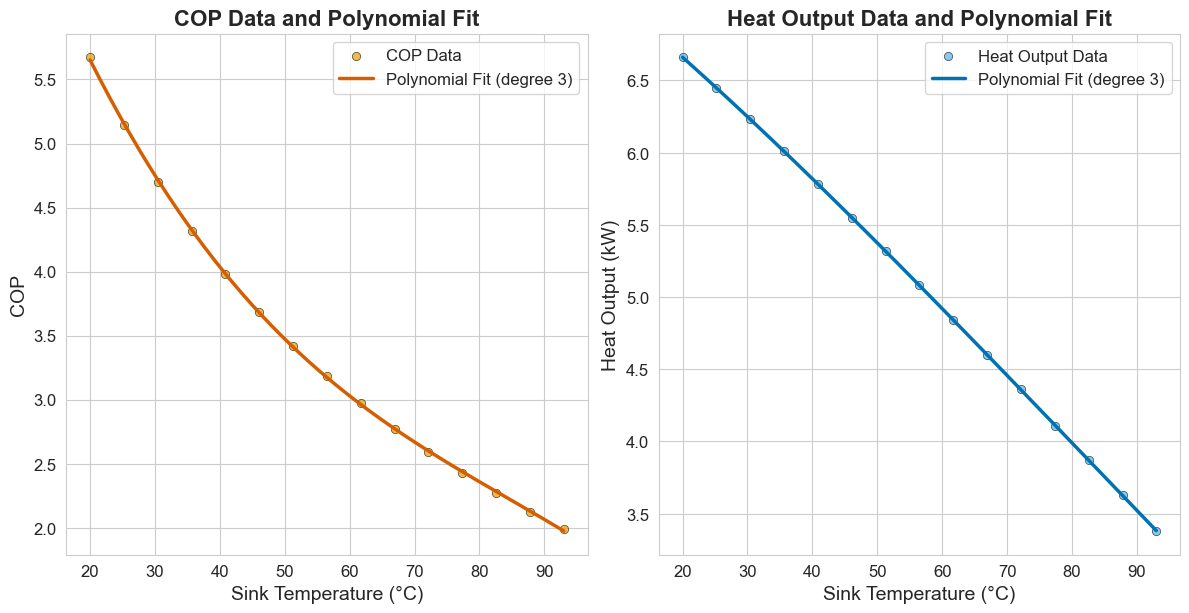

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")

palette = {
    "cop_data": "#E69F00",
    "cop_fit": "#D55E00",
    "heat_data": "#56B4E9",
    "heat_fit": "#0072B2"
}

T_plot = np.linspace(20, 93, 200)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Make each axes box square
ax1.set_box_aspect(1)
ax2.set_box_aspect(1)

# --- Left plot: COP ---
ax1.scatter(*zip(*COP_DATA), color=palette["cop_data"], label='COP Data', alpha=0.7, edgecolor='k', linewidth=0.5)
COP_fit_vals = [get_COP_from_fit(T, get_heat_from_fit(T)) for T in T_plot]
ax1.plot(T_plot, COP_fit_vals, color=palette["cop_fit"], lw=2.5, label=f'Polynomial Fit (degree {COP_POLY_DEGREE})')

ax1.set_xlabel('Sink Temperature (°C)', fontsize=14)
ax1.set_ylabel('COP', fontsize=14)
ax1.set_title('COP Data and Polynomial Fit', fontsize=16, weight='bold')
ax1.legend(fontsize=12)
ax1.grid(True)
ax1.tick_params(axis='both', labelsize=12)

# --- Right plot: Heat Output ---
heat_temps, heat_vals = zip(*sorted(heat_dict.items()))
ax2.scatter(heat_temps, heat_vals, color=palette["heat_data"], label='Heat Output Data', alpha=0.7, edgecolor='k', linewidth=0.5)
heat_fit_vals = [get_heat_from_fit(T) for T in T_plot]
ax2.plot(T_plot, heat_fit_vals, color=palette["heat_fit"], lw=2.5, label=f'Polynomial Fit (degree {HEAT_POLY_DEGREE})')

ax2.set_xlabel('Sink Temperature (°C)', fontsize=14)
ax2.set_ylabel('Heat Output (kW)', fontsize=14)
ax2.set_title('Heat Output Data and Polynomial Fit', fontsize=16, weight='bold')
ax2.legend(fontsize=12)
ax2.grid(True)
ax2.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.savefig("poly_fit.png", dpi=600)

plt.show()


In [ ]:
import pandas as pd
import numpy as np
import json

# --- Read valid results from file ---
with open("valid_results.txt", "r") as f:
    valid_results = json.load(f)

# --- List to store summary rows ---
summary_rows = []

# --- Loop over each configuration ---
for config in valid_results:
    best_T_on = config["T_on"]
    best_T_off = config["T_off"]
    diameter = config.get("diameter")
    fluid = config.get("fluid")

    # --- Step 1: Preliminary heat-up simulation ---
    prelim_duration = 3 * 60 * 60
    op_times_prelim = []

    _, _, T_water_prelim, _, prelim_start_index = T_water_and_pasta_with_heatup(
        best_T_on, best_T_off, prelim_duration, op_times_prelim, m_water, m_pasta
    )

    heating_up_time = prelim_start_index  # seconds

    # --- Step 2: Full simulation ---
    duration_seconds = heating_up_time + 12 * 60 * 60
    op_times = []

    t, Q_WPs, T_water, T_pasta, start_index = T_water_and_pasta_with_heatup(
        best_T_on, best_T_off, duration_seconds, op_times, m_water, m_pasta
    )

    Q_kW = np.array(Q_WPs) / 1000
    power_needed_kWh = sum(Q_kW) / 3600  # convert from kW·s to kWh

    # --- Step 3: Store summary row ---
    summary_rows.append({
        "fluid": fluid,
        "diameter": diameter,
        "T_on": best_T_on,
        "T_off": best_T_off,
        "power_needed_kWh": power_needed_kWh,
        "num_cycles": len(op_times),
        "heatup_time_min": heating_up_time / 60
    })

summary_df = pd.DataFrame(summary_rows)
# Step 1: Filter out entries with more than 61 cycles
filtered_df = summary_df[summary_df["num_cycles"] <= 61].copy()

# Step 2: For each (fluid, diameter), keep only the row with lowest power_needed_kWh
best_per_config = (
    filtered_df
    .sort_values("power_needed_kWh")  # sort so lowest power comes first
    .drop_duplicates(subset=["fluid", "diameter"], keep="first")  # keep only best power
    .reset_index(drop=True)
)

# --- Optional: Save to CSV ---
best_per_config.to_csv("simulation_summary.csv", index=False)

print("\n✅ Simulation summary saved to DataFrame `best_per_config` and written to 'simulation_summary.csv'.")
